# Introduction to machine learning 2022 term project

In [1]:
# general imports
import pandas as pd
import numpy as np

# sklearn models
from sklearn.model_selection import cross_validate,cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,BayesianRidge
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier


#Feature selection imports
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
npf = pd.read_csv("npf_train.csv")
hidden_test = pd.read_csv("npf_test_hidden.csv")

## Data preprocessing

Column "class2" added that is "event" if "class4" is Ib, Ia or II, otherwise labeled as "nonevent". 

In [3]:
class2 = np.array(["nonevent", "event"])
npf["class2"] = class2[(npf["class4"]!="nonevent").astype(int)]


## PCA 
PCA was performed inorder to help with the selection of component and for visualization of data.

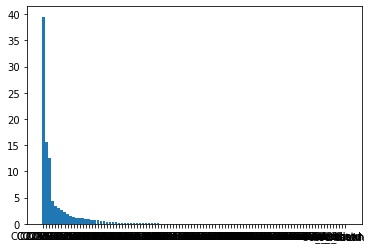

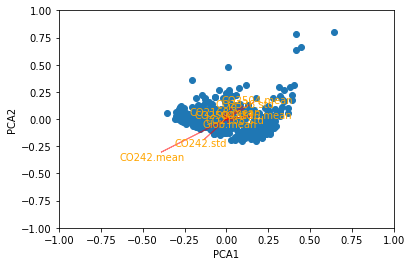

In [4]:
# Visualiserar features, använder PCA för att välja mest passande komponenterna.

from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import preprocessing

npf_dropped = npf.drop(["date", "class4", "class2", "partlybad"], axis =1)
scaled = preprocessing.scale(npf_dropped)

pca = PCA()
pca.fit(scaled)
pca_data = pca.transform(scaled)

# Räknar hur många procent varje component påverkar modellen.
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
#labels = ["PC" + str (x) for x in range(1, len(per_var)+1)]
labels=npf_dropped.columns

# Gör ett histogram som avslöjar vilka features är viktigast

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.xlabel = "Principal component"
plt.ylabel = "Percentage of explanation variable"
plt.title = "Importance of principal components (%)"

# Gör en biplot plot
pca_df = pd.DataFrame(pca_data, columns = labels)

# på "score" parametern välj de kolumner du vill jämföra, "coeff" ger riktningen för maximala varianserna i datan,
# "labels" ger namnet på pca:n. Funkar dock enbart om man tar alla komponenter börjandes från första.
def biplot(score, coeff, labels = None):
    x_axis = score[:,0]
    y_axis = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(x_axis.max() - x_axis.min())
    scaley = 1.0/(y_axis.max() - y_axis.min())
    fig, ax = plt.subplots()
    
    ax.scatter(x_axis*scalex, y_axis*scaley)
    
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        ax.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color = 'orange', ha = 'center', va = 'center')
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_xlabel("PCA1")
        ax.set_ylabel("PCA2")

biplot(pca_data[:,0:10], pca.components_[0:10, :], labels = labels)

## Feature selection and test/train splitting 

In [5]:
selected_features=["RHIRGA42.mean",
                   "RGlob.mean",
                   "O3504.mean",
                   "T84.std",
                   "SWS.mean",
                   "PTG.mean",
                   "CO2504.std",
                   "NOx504.std",
                   "CS.mean",
                   "NO672.std"]
train, test = train_test_split(npf[["class2"]+selected_features],test_size=0.33, random_state=42)
print("Train size:", len(train),"Test size:", len(test))

Train size: 310 Test size: 154


In [20]:
X = train[selected_features]
#X = train.filter(regex=".mean")
y = train["class2"]
X_test = test[selected_features]
y_test = test["class2"]

## Benchmarking
At this point several different classifiers were tested inorder to get an idea of their relative performance.

In [21]:
Classifier_Names = ["dummyRegressor",
                    "logisticRegressor",
                    "GaussianNaiveBays",
                    "SVC",
                    "SVC-sigmoid",
                    "SVC-poly",
                    "RandomForest",
                    "AdaBoost",
                    "NearestNeighbour",
                    "GaussianProcess",
                    "QDA",
                    "DecisionTree"]


classifiers = [DummyClassifier(strategy="prior"),
          LogisticRegression(penalty="l1",solver="liblinear"),
          GaussianNB(),
          SVC(probability=True),
          SVC(kernel="sigmoid",probability=True),
          SVC(kernel="poly",probability=True),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          KNeighborsClassifier(3),
          GaussianProcessClassifier(1.0 * RBF(1.0)),
          QuadraticDiscriminantAnalysis(),
          DecisionTreeClassifier(max_depth=5)
          ]
models = [Pipeline([("feature_selection",SelectKBest(f_classif, k = 8)),("classifier",c)]) for c in classifiers]
res = pd.DataFrame(index=Classifier_Names)

In [22]:
perplexity = lambda p: np.exp(-np.mean(np.log((test["class2"]!="nonevent").astype(int)*p + (1 - (test["class2"]!="nonevent").astype(int)) * (1 - p))))

In [23]:
res["train"] = [m.fit(X,y).score(X,y) for m in models]
res["cv"] = [cross_val_score(m, X, y, cv=10).mean() for m in models]
res["test"] = [m.fit(X,y).score(X_test,y_test) for m in models]
#res["perplexity"] = [perplexity(m.fit(X,y).predict_proba(X_test)[:,1]) for m in models]

In [24]:
res

,train,cv,test
dummyRegressor,0.477419,0.477419,0.545455
logisticRegressor,0.574194,0.558065,0.603896
GaussianNaiveBays,0.590323,0.551613,0.564935
SVC,0.477419,0.477419,0.545455
SVC-sigmoid,0.477419,0.477419,0.545455
SVC-poly,0.477419,0.477419,0.545455
RandomForest,1.000000,0.638710,0.675325
AdaBoost,0.641935,0.577419,0.623377
NearestNeighbour,0.729032,0.554839,0.564935
GaussianProcess,0.609677,0.593548,0.610390


## Choise of model
At this point we chose the logistic regression as the model for the production version of the classifier as it performed well and is a model that has good explainability. 

In [25]:
clf = Pipeline([
    ("feature_selection",SelectKBest(f_classif, k = 10)),
    ("classifier",LogisticRegression(penalty="l1",solver="liblinear"))])

clf.fit(X,y)

Pipeline(steps=[('feature_selection', SelectKBest()),
                ('classifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [12]:
stats = pd.DataFrame(index=["logistic regression"], columns=["train","test","perplexity"])

stats["train"]      = clf.score(X,y)
stats["test"]       = clf.score(X_test,y_test)
stats["perplexity"] = perplexity(clf.predict_proba(X_test)[:,1])
stats

,train,test,perplexity
logistic regression,0.793548,0.805195,5.810911


## Production version and prediction of hidden test data 

In [13]:
X_prod = npf[selected_features]
y_prod = npf["class2"]
clf.fit(X_prod,y_prod)
print("Training score:",clf.score(X_prod,y_prod))

Training score: 0.7931034482758621


In [14]:
hidden_test["class2"] = clf.predict(hidden_test[selected_features])
hidden_test.to_csv("answers.csv")

## Multi-class classifier

In [16]:
train, test = train_test_split(npf[["class4"]+selected_features],test_size=0.33, random_state=42)
X = train[selected_features]
#X = train.filter(regex=".mean")
y = train["class4"]
X_test = test[selected_features]
y_test = test["class4"]

In [26]:
clf.fit(X,y)

Pipeline(steps=[('feature_selection', SelectKBest()),
                ('classifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [27]:
stats = pd.DataFrame(index=["logistic regression"], columns=["train","test"])
stats["train"]      = clf.score(X,y)
stats["test"]       = clf.score(X_test,y_test)
stats

,train,test
logistic regression,0.619355,0.655844


In [28]:
clf.predict(hidden_test[selected_features])

array(['nonevent', 'Ib', 'nonevent', 'nonevent', 'nonevent', 'nonevent',
       'nonevent', 'nonevent', 'II', 'nonevent', 'nonevent', 'nonevent',
       'nonevent', 'II', 'nonevent', 'II', 'nonevent', 'nonevent',
       'nonevent', 'nonevent', 'Ib', 'nonevent', 'nonevent', 'nonevent',
       'II', 'nonevent', 'nonevent', 'II', 'II', 'II', 'Ib', 'II',
       'nonevent', 'II', 'Ib', 'nonevent', 'nonevent', 'nonevent',
       'nonevent', 'II', 'nonevent', 'II', 'nonevent', 'II', 'nonevent',
       'nonevent', 'nonevent', 'nonevent', 'nonevent', 'II', 'nonevent',
       'nonevent', 'nonevent', 'Ib', 'nonevent', 'II', 'nonevent', 'Ib',
       'II', 'nonevent', 'nonevent', 'nonevent', 'Ib', 'II', 'II',
       'nonevent', 'II', 'nonevent', 'nonevent', 'nonevent', 'nonevent',
       'nonevent', 'II', 'nonevent', 'Ib', 'Ib', 'nonevent', 'nonevent',
       'Ib', 'nonevent', 'II', 'nonevent', 'nonevent', 'nonevent', 'II',
       'nonevent', 'nonevent', 'nonevent', 'nonevent', 'II', 'nonevent',
  